# Challenge 2 - Francesco Ortu

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from fast_soft_sort.pytorch_ops import soft_sort

%load_ext autoreload
%autoreload 2


# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

## Define group class

Frist, we create two classes to represent the cyclic group $C_N$, plot and handle the operation($+$):

In [2]:
from typing import Any


class Group_element():
    def __init__(self, cos, sin):
        self.cos = cos
        self.sin = sin
    
    def __repr__(self) -> str:
        return f"Group_element({self.cos}, {self.sin})"
        
    def __add__(self, other):
        cos = self.cos * other.cos - self.sin * other.sin
        sin = self.sin * other.cos + self.cos * other.sin
        return Group_element(cos, sin)
    
    def __eq__(self, other):
        print(self.cos, other.cos, self.sin, other.sin)
        return self.cos == other.cos and self.sin == other.sin
    
    def __call__(self):
        return (self.cos, self.sin)
    
    def item(self):
        return (self.cos, self.sin)

class Group:
    def __init__(self, n):
        self.n = n 
        self.group = self.make_group(n)
    
    def __getitem__(self, k):
        return self.group[k]
    
    def __contains__(self, element):
        for e in self.group:
            if e == element:
                return True
    
    def __repr__(self) -> str:
        return self.group.__repr__()
        
    def make_group(self,n):
        group = []
        for i in range(n):
            group.append(self.get_element(i, n))
        return group
        
    def get_element(self,k, n):
        cos = round(math.cos((2 * math.pi *k)/n), 3)
        sin = round(math.sin((2 * math.pi *k)/n), 3)
        return Group_element(cos, sin)

    def plot(self, points=None):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_box_aspect(1)
        ax.set_aspect('equal')
        
        ax.scatter(*zip(*[x.item() for x in self.group]), s=30, color='red')
        if points:
            ax.scatter(*zip(*[x.item() for x in points]), s=30, color='blue', marker='x')
        circle = plt.Circle((0, 0), 1, fill=False, color='grey')
        ax.add_artist(circle)
        
        # Draw the axes.
        plt.axhline(0,color='grey')
        plt.axvline(0,color='grey')
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        x_range = x_max - x_min
        y_range = y_max - y_min
        ax.set_xlim(x_min - 0.1*x_range, x_max + 0.1*x_range)
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        
        plt.show()

Let's plot the group and verify the closure property:

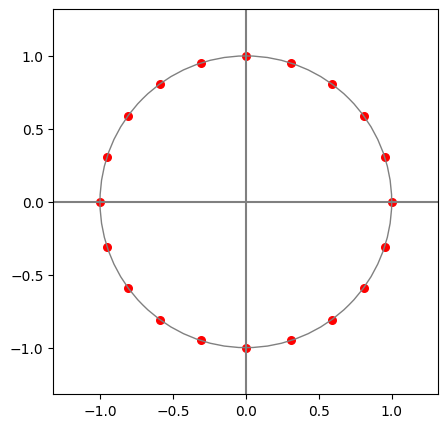

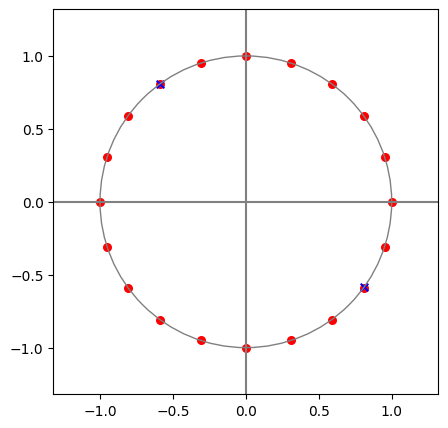

In [3]:
group = Group(20)
group.plot()
group.plot([group[3]+group[4], group[1]+group[17]])

## Generate dataset

In [8]:

from dataclasses import dataclass

@dataclass
class Config:
    group_size: int = 250
    num_labels: int = 10

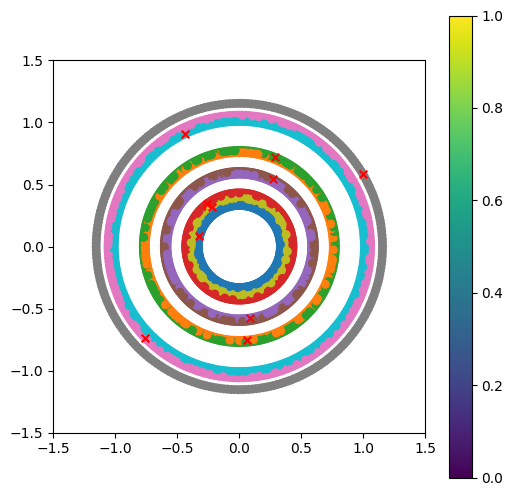

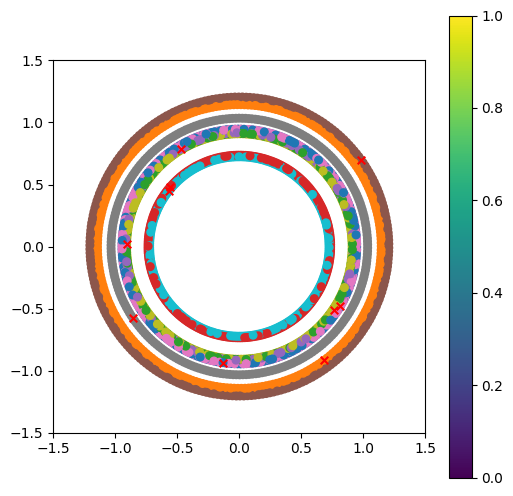

In [9]:
rotation_group = Group(Config.group_size)

# Generate a set of random 2-dimensional vectors
num_vectors = Config.num_labels
num_eval = Config.num_labels
vectors = [(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(num_vectors)]
eval_vectors = [(random.uniform(-1, 1), random.uniform(-1, 1)) for _ in range(num_eval)]

# Apply rotations to the vectors using the rotation group
rotated_vectors = []
labels = []
for i,v in enumerate(vectors):
    orbit = set()
    for g in rotation_group:
        rotated = (g.cos*v[0] - g.sin*v[1], g.sin*v[0] + g.cos*v[1])
        orbit.add(rotated)
    rotated_vectors.extend(list(orbit))
    labels.extend([i for _ in range(len(orbit))])

# Shuffle the dataset
dataset = list(zip(rotated_vectors, labels))
random.shuffle(dataset)

# Separate the dataset into inputs (vectors) and targets (labels)
inputs = [d[0] for d in dataset]
targets = [d[1] for d in dataset]

# Apply rotations to the vectors using the rotation group
eval_rotated_vectors = []
eval_labels = []
for i,v in enumerate(eval_vectors):
    orbit = set()
    for g in rotation_group:
        rotated = (g.cos*v[0] - g.sin*v[1], g.sin*v[0] + g.cos*v[1])
        orbit.add(rotated)
    eval_rotated_vectors.extend(list(orbit))
    eval_labels.extend([i for _ in range(len(orbit))])

# Shuffle the dataset
eval_dataset = list(zip(eval_rotated_vectors, eval_labels))
random.shuffle(eval_dataset)

# Separate the dataset into inputs (vectors) and targets (labels)
eval_inputs = [d[0] for d in eval_dataset]
eval_targets = [d[1] for d in eval_dataset]


# Plot the inputs colored by their targets
plt.figure(figsize=(6, 6))
plt.scatter([p[0] for p in inputs], [p[1] for p in inputs], c=targets, cmap='tab10', s=30) 
plt.scatter(*zip(*vectors), s=30, color='red', marker='x')
plt.colorbar()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# plot eval inputs
plt.figure(figsize=(6, 6))
plt.scatter([p[0] for p in eval_inputs], [p[1] for p in eval_inputs], c=eval_targets, cmap='tab10', s=30)
plt.scatter(*zip(*eval_vectors), s=30, color='red', marker='x')
plt.colorbar()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# to tensor
import torch
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)

eval_inputs = torch.tensor(eval_inputs)
eval_targets = torch.tensor(eval_targets)

## Define the model and the loss function

In [11]:
class MyLoss(nn.Module):
    def __init__(self, lambda_ = 1, alpha=1, beta=1):
        super().__init__()
        self.lambda_ = lambda_
        self.alpha = alpha
        self.beta = beta
        self.cross_entropy = torch.nn.CrossEntropyLoss()
        
    def regularizer1(self, weight_matrix):
        # rows
        row_matrix = soft_sort(weight_matrix)
        norms_sum_rows = 0
        for i in range(1,row_matrix.shape[0]):
            norms_sum_rows += torch.norm(row_matrix[0,:] - row_matrix[i,:]) **2
        
        # columns
        col_matrix = soft_sort(weight_matrix.T)
        norms_sum_cols = 0
        for i in range(1,col_matrix.shape[0]):
            norms_sum_cols += torch.norm(col_matrix[0,:] - col_matrix[i,:])**2
        
        return  norms_sum_cols + norms_sum_rows
        
    def commutator(self, A, B):
        return A @ B - B @ A
    
    def regularizer2(self, A, B):
        return torch.norm(self.commutator(A,B))**2
    
    def forward(self, preds, targets, gramian = None, A = None, B = None):
        return self.cross_entropy(preds, targets)  + self.lambda_ * self.regularizer1(gramian) + self.beta * torch.norm(self.commutator(A,B))**2
    

## simple classifier

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( nn.Linear(2, 20, bias=True),
                                 nn.ReLU(),
                                nn.Linear(20,Config.num_labels),
                                 )
    def forward(self, x):
        x = self.net(x)
        return x

100%|██████████| 500/500 [00:22<00:00, 22.14it/s]


train accuracy:  0.9328
tensor([[59.0648,  0.1068],
        [ 0.1068, 58.8859]], grad_fn=<MmBackward0>)


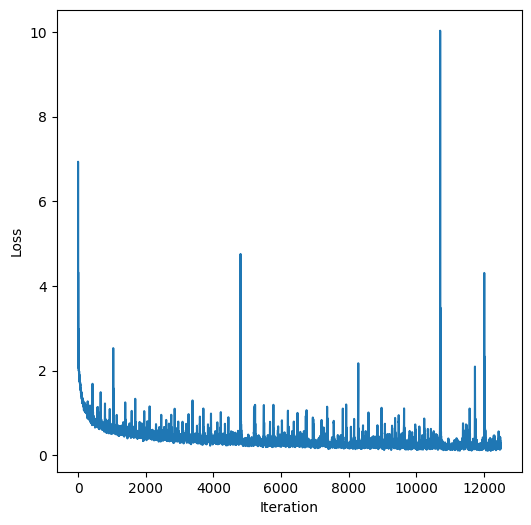

In [13]:
# setting up the trainloader
trainloader = DataLoader(list(zip(inputs, targets)), batch_size=100, shuffle=True)
model = Classifier()

inputs_matrix = inputs.T @ inputs

# setting up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

loss_fn = MyLoss()
# loss_fn = torch.nn.CrossEntropyLoss()
model.to(DEVICE)
inputs = inputs.to(DEVICE)
targets = targets.to(DEVICE)
saved_loss = []
for i in tqdm(range(500)):
    for x, y in trainloader:
        optimizer.zero_grad()
        pred = model(x)
        # A, B = get_matrixes(model.net[0].weight, inputs)
        loss = loss_fn(pred, y, model.net[0].weight.T @ model.net[0].weight, inputs_matrix, model.net[0].weight.T @ model.net[0].weight)
        # loss = loss_fn(pred,targets)
        loss.backward()
        optimizer.step()
        saved_loss.append(loss.item())
    # print(loss.item()   )

# compute train accuracy
pred = model(inputs)
pred = torch.argmax(pred, dim=1)
print("train accuracy: ", (pred == targets).sum().item() / len(targets))

print(model.net[0].weight.T @ model.net[0].weight)
#plot loss
# Plot the loss
plt.figure(figsize=(6, 6))
plt.plot(saved_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()



In [95]:
# gramian
print(model.net[0].weight.T @ model.net[0].weight)


tensor([[49.8749, -0.5559],
        [-0.5559, 50.3507]], grad_fn=<MmBackward0>)

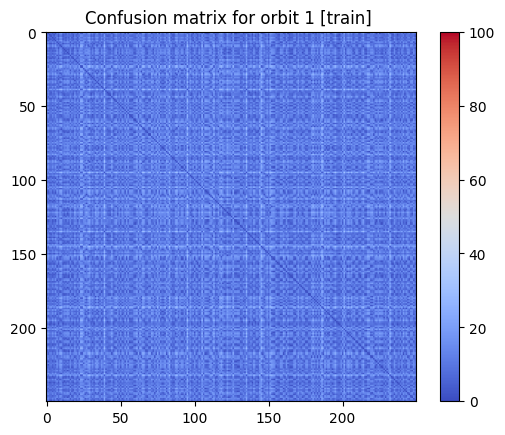

AttributeError: module 'numpy' has no attribute 'norm'

In [96]:
# select a random orbit
orbit = 1
orbit_indices1 = [i for i in range(len(inputs)) if targets[i] == orbit]
orbit_elements = [inputs[i] for i in orbit_indices1]
phi = model.net[0].weight.T @ model.net[0].weight

# confusion matrix
train_matrix = []
for x in orbit_elements:
    row = []
    for y in orbit_elements:
        phi_x = model(x)
        phi_y = model(y)
        # sort the elements of phi_x and phi_y
        phi_x_sorted = torch.sort(phi_x, descending=True).values
        phi_y_sorted = torch.sort(phi_y, descending=True).values
        # compute the distance between the sorted vectors
        row.append(torch.norm(phi_x - phi_y).item())
        
    train_matrix.append(row)

# plot the confusion train_matrix
# plt.figure(figsize=(6, 6))
plt.imshow(train_matrix, cmap='coolwarm')
plt.colorbar()
plt.clim(0, 100)
plt.title(f"Confusion matrix for orbit {orbit} [train] ")
plt.show()





# select a random orbit
orbit = 1
orbit_indices = [i for i in range(len(eval_inputs)) if eval_targets[i] == orbit]
orbit_indices1 = [i for i in range(len(inputs)) if targets[i] == 0]
orbit_elements1 = [inputs[i] for i in orbit_indices1]
orbit_elements = [eval_inputs[i] for i in orbit_indices]


# confusion matrix
eval_matrix = []
for x in orbit_elements:
    row = []
    for y in orbit_elements:
        phi_x = model(x)
        phi_y = model(y)
        # sort the elements of phi_x and phi_y
        
        
        phi_x_sorted = torch.sort(phi_x, descending=True).values
        phi_y_sorted = torch.sort(phi_y, descending=True).values
        
        # compute the distance between the sorted vectors
        row.append(torch.norm(phi_x_sorted - phi_y_sorted).item())
        
    eval_matrix.append(row)

# plot the confusion eval_matrix
# plt.figure(figsize=(6, 6))
plt.imshow(eval_matrix, cmap='coolwarm')
plt.colorbar()
plt.clim(0, 100)
plt.title(f"Confusion matrix for orbit {orbit} [eval] ")
plt.show()

# confusion matrix
eval_matrix = []
for x in orbit_elements:
    row = []
    for y in orbit_elements1:
        phi_x = model(x)
        phi_y = model(y)
        # sort the elements of phi_x and phi_y
        
        
        phi_x_sorted = torch.sort(phi_x, descending=True).values
        phi_y_sorted = torch.sort(phi_y, descending=True).values
        
        # compute the distance between the sorted vectors
        row.append(torch.norm(phi_x_sorted - phi_y_sorted).item())
        
    eval_matrix.append(row)

# plot the confusion eval_matrix
plt.figure(figsize=(6, 6))
plt.imshow(eval_matrix, cmap='coolwarm')
plt.colorbar()
plt.clim(0, 100)
plt.title(f"Confusion matrix for orbit {orbit} and 0 [eval] ")
plt.show()

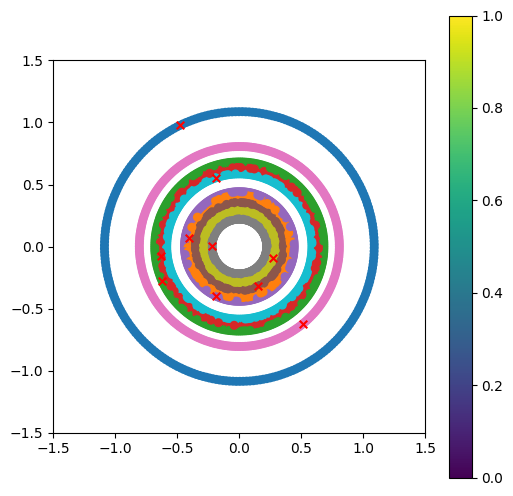

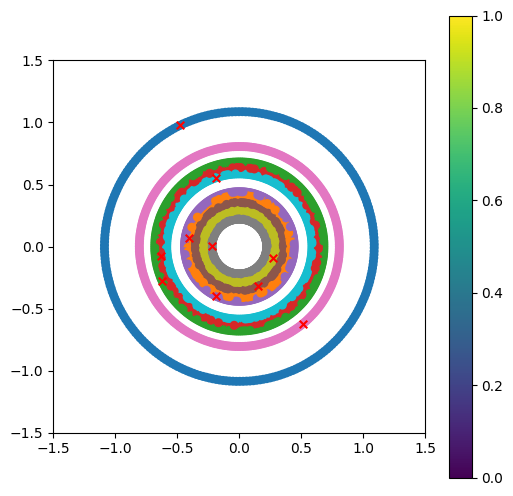

In [68]:
inputs = inputs.cpu()
# Plot the inputs colored by their targets
plt.figure(figsize=(6, 6))
plt.scatter([p[0] for p in inputs], [p[1] for p in inputs], c=targets, cmap='tab10', s=30)
plt.scatter(*zip(*vectors), s=30, color='red', marker='x')
plt.colorbar()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')


model.eval()
# get the predictions
preds = model(inputs)
#get the argmax of the predictions
preds = preds.argmax(1)
# Plot the inputs colored by their predictions
plt.figure(figsize=(6, 6))
plt.scatter([p[0] for p in inputs], [p[1] for p in inputs], c=preds, cmap='tab10', s=30)
plt.scatter(*zip(*vectors), s=30, color='red', marker='x')
plt.colorbar()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()